Importing and Initalising Libraries for Task 1

In [2]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import os

from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

import scipy.cluster as sc
import scipy.spatial.distance as sd
from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

Reading Basel Climate Data using Pandas.Read_CSV, then displaying first ten entries

In [3]:
filePath = 'ClimateDataBasel.csv'
baselData = pd.read_csv(filePath)
baselData.head(10)

,Temperature (Min) oC.,Temperature (Max) oC.,Temperature (Mean) oC.,Relative Humidity (Min) %.,Relative Humidity (Max) %.,Relative Humidity (Mean) %.,Sea Level Pressure (Min) hPa.,Sea Level Pressure (Max) hPa.,Sea Level Pressure (Mean) hPa.,Precipitation Total mm.,Snowfall Amount cm.,Sunshine Duration min.,Wind Gust (Min) Km/h.,Wind Gust (Max) Km/h.,Wind Gust (Mean) Km/h.,Wind Speed (Min) Km/h.,Wind Speed (Max) Km/h.,Wind Speed (Mean) Km/h.
0,8.100529,17.570530,13.445111,61,96,77.875000,1013.1,1018.4,1015.75830,0.2,0.0,350.56274,3.240000,23.400000,12.210002,1.787066,10.403253,6.639939
1,11.110529,18.490528,14.988861,59,94,76.458336,1013.9,1016.6,1014.99170,1.9,0.0,287.23404,6.479999,25.199999,14.880001,4.161301,16.285300,8.616541
2,10.320529,18.170528,14.267612,71,96,83.583336,1015.3,1017.5,1016.38745,0.1,0.0,126.26506,3.240000,24.119999,12.764999,2.028842,11.289829,6.372418
3,10.450529,24.980530,17.309278,54,92,77.625000,1015.9,1018.7,1017.26250,0.0,0.0,881.24710,2.160000,20.160000,9.480000,0.799200,11.483046,4.690738
4,12.350529,25.610529,19.881780,47,88,66.583336,1015.7,1020.7,1018.18353,0.0,0.0,951.56665,0.720000,15.840000,5.565001,0.376746,6.443357,3.311275
5,17.690529,26.250528,21.623444,57,91,69.500000,1012.6,1015.7,1014.59160,1.1,0.0,440.98970,1.080000,41.760002,13.500000,1.787066,16.802220,6.217993
6,15.270529,22.650530,19.308447,54,91,72.000000,1010.3,1015.8,1013.59576,0.3,0.0,666.70210,0.720000,32.760002,16.935001,0.376746,12.300643,7.435599
7,14.680529,24.170528,20.224280,62,89,75.083336,1005.6,1010.2,1007.73750,1.4,0.0,49.47872,0.360000,11.159999,5.310000,0.000000,7.920641,3.995119
8,15.470529,27.880530,22.057198,49,89,74.291664,1003.2,1006.7,1005.01250,0.3,0.0,433.48175,3.240000,27.720000,11.985001,2.382754,16.021694,7.938655
9,16.920528,30.720530,22.644693,39,97,73.458336,1001.4,1005.7,1003.80835,0.0,0.0,531.93730,1.440000,24.119999,12.209999,1.864800,15.137991,6.780077


Generating Boxplots of baselData Data to inform Outlier Removal

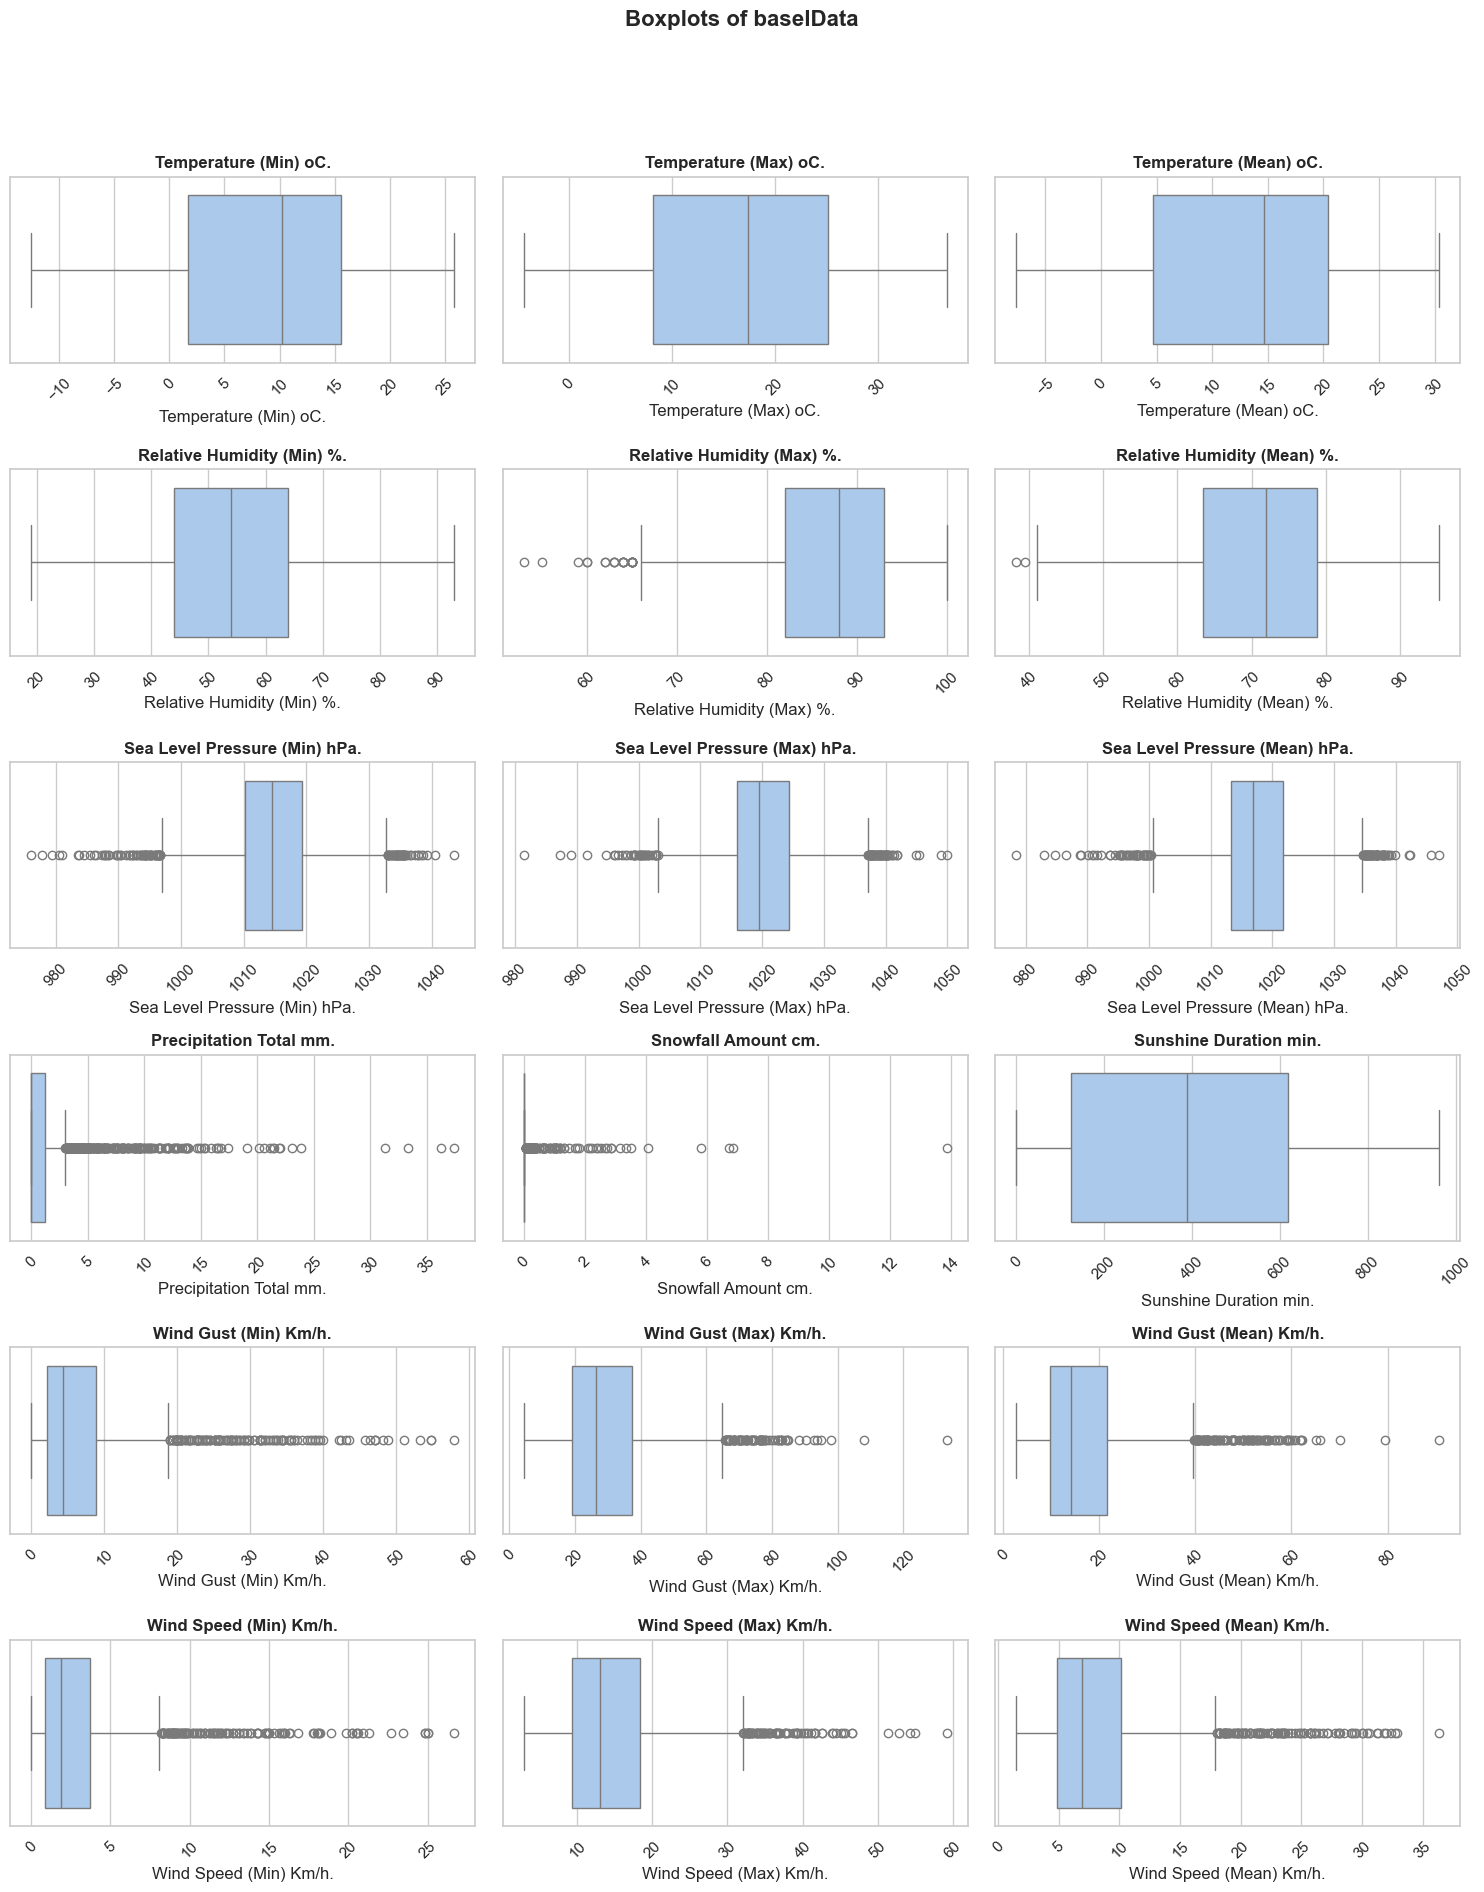

In [4]:

def violinplot(column):
    sns.violinplot(baselData, x=baselData[f"{column}"])
    plt.title(f"{column}")
    plt.show

columns = list(baselData.keys())
sns.set(style="whitegrid", palette="pastel", rc={"figure.figsize": (15, 18)})
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 18))
axes = axes.flatten() #flatten the axes array 
for i, col in enumerate(columns):
    sns.boxplot(data=baselData, x=col, ax=axes[i]) #create  boxplot 
    axes[i].set_title(col, fontsize=12, weight='bold')  
    axes[i].tick_params(axis='x', rotation=45)  
fig.suptitle('Boxplots of baselData', fontsize=16, weight='bold', y=1.05)
plt.tight_layout()
plt.savefig("Initial Boxplots of baselData.png")
plt.show()


Creating function IQRforOutliers to use IQR to remove Outliers at .25 and .75 quantiles

In [5]:
def IQRforOutliers(df):
    numericalCols = df.select_dtypes(include=['number']).columns
    Q1 = df[numericalCols].quantile(0.25)
    Q3 = df[numericalCols].quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR
    dfNoOutliers = df[~((df[numericalCols] < lowerBound) | (df[numericalCols] > upperBound)).any(axis=1)]
    dfOutliers = df[((df[numericalCols] < lowerBound) | (df[numericalCols] > upperBound)).any(axis=1)]

    return dfNoOutliers, dfOutliers

baselDataNoOutliersIQR, baselDataOutliersIQR = IQRforOutliers(baselData)

print(f"Original Data Shape: {baselData.shape}")
print(f"After Outlier Removal: {baselDataNoOutliersIQR.shape}")
print(f"Outliers: {baselDataOutliersIQR.shape}")

Original Data Shape: (1763, 18)
After Outlier Removal: (1179, 18)
Outliers: (584, 18)


Creating functions to plot Scatterplot of Outliers v.s Non-Outliers from IQR Results

Plot saved as Scatterplot_Output_2.png


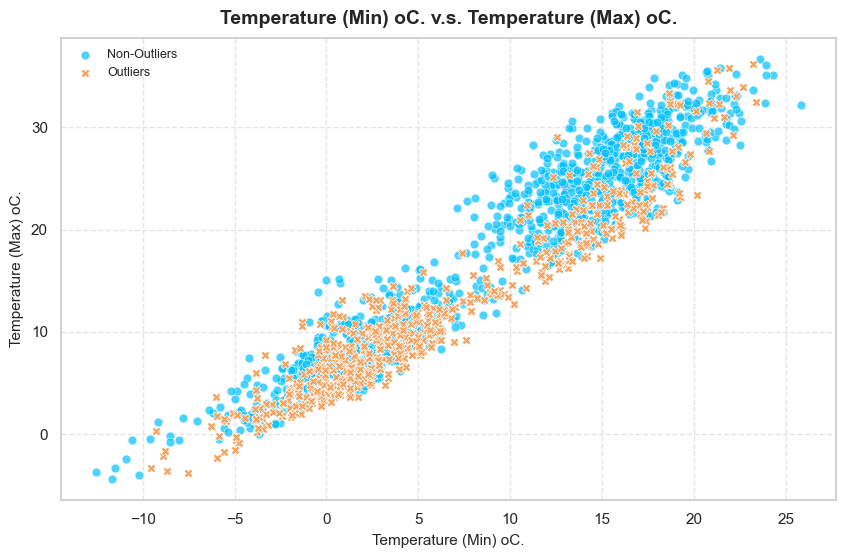

In [6]:
def get_unique_filename(baseFilename: str, extension: str='.png'):
    filename = f"{baseFilename}{extension}"
    counter = 1
    while os.path.exists(filename):
        filename = f"{baseFilename}_{counter}{extension}"
        counter +=1
    return filename

def PlotScatterAndOutliers(dfNoOutliers: pd.DataFrame, dfOutliers: pd.DataFrame, baseFilename):

    sns.set_theme(style='whitegrid', palette='pastel')

    numericalCols = dfNoOutliers.select_dtypes(include=['number']).columns

    if len(numericalCols) < 2:
        print("More Numerical Columns required for plot.")
        return   
    
    xCol = numericalCols[0]
    yCol = numericalCols[1]

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=dfNoOutliers, x=xCol, y=yCol, color='deepskyblue', label='Non-Outliers', alpha=.7, s=40)
    sns.scatterplot(data=dfOutliers, x=xCol, y=yCol, color='sandybrown', label='Outliers', marker='X',s=40)

    plt.xlabel(xCol, fontsize=11, labelpad=5)
    plt.ylabel(yCol, fontsize=11, labelpad=5)

    plt.title(f'{xCol} v.s. {yCol}', fontsize=14, weight='bold', pad=10)

    plt.legend(fontsize=9, loc='upper left', frameon=False)
    plt.grid(True, linestyle='--', alpha=.5)
    plt.tight_layout

    filename = get_unique_filename(baseFilename)
    plt.savefig(filename, dpi=300)
    print(f"Plot saved as {filename}")

    plt.show()

baseFilename="Scatterplot_Output"
PlotScatterAndOutliers(baselDataNoOutliersIQR, baselDataOutliersIQR, baseFilename)

Converting baselData to Pandas DataFrame, then checking for any NULL/NA Columns and filling any potential columns with 'NA'

In [7]:
baselData = pd.DataFrame(baselData)

nullCount = baselData.isna().sum()
print(nullCount)

baselData= baselData.fillna('NA')
print(baselData.keys())

Temperature (Min) oC.             0
Temperature (Max) oC.             0
Temperature (Mean) oC.            0
Relative Humidity (Min) %.        0
Relative Humidity (Max) %.        0
Relative Humidity (Mean) %.       0
Sea Level Pressure (Min) hPa.     0
Sea Level Pressure (Max) hPa.     0
Sea Level Pressure (Mean) hPa.    0
Precipitation Total mm.           0
Snowfall Amount cm.               0
Sunshine Duration min.            0
Wind Gust (Min) Km/h.             0
Wind Gust (Max) Km/h.             0
Wind Gust (Mean) Km/h.            0
Wind Speed (Min) Km/h.            0
Wind Speed (Max) Km/h.            0
Wind Speed (Mean) Km/h.           0
dtype: int64
Index(['Temperature (Min) oC.', 'Temperature (Max) oC.',
       'Temperature (Mean) oC.', 'Relative Humidity (Min) %.',
       'Relative Humidity (Max) %.', 'Relative Humidity (Mean) %.',
       'Sea Level Pressure (Min) hPa.', 'Sea Level Pressure (Max) hPa.',
       'Sea Level Pressure (Mean) hPa.', 'Precipitation Total mm.',
       'Sn

In [8]:
scaler = StandardScaler()
baselDataStandardised = scaler.fit_transform(baselData)
baselDataStandardised

array([[-0.08181097,  0.08203517,  0.08283132, ..., -0.33021648,
        -0.56620916, -0.34182459],
       [ 0.30401292,  0.17742085,  0.25853574, ...,  0.35404395,
         0.18128544,  0.03798953],
       [ 0.20275017,  0.14424315,  0.17644561, ..., -0.26053593,
        -0.45354247, -0.39323011],
       ...,
       [-1.18801039, -1.30106042, -1.29036621, ..., -0.50189538,
        -0.58059165, -0.47343986],
       [-1.06367512, -0.93506888, -1.06989391, ..., -0.76847601,
        -0.94701493, -0.93261547],
       [-0.74065978, -0.85212459, -0.84349369, ..., -0.76847601,
        -1.08927164, -0.82247554]])

In [9]:
def normalise(data):
    normalisedData = data.copy()

    rows = data.shape[0]
    cols = data.shape[1]

    for j in range(cols):
        maxEl = np.amax(data[:, j])
        minEl = np.amin(data[:, j])

        for i in range(rows):
            normalisedData[i, j] = (data[i, j] - minEl) / (maxEl - minEl)

        return normalisedData
         
def normalise2(data):
    normalisedData = data.copy()

    rows = data.shape[0]
    cols = data.shape[1]

    for j in range(cols):
        maxEl = np.amax(data[:, j])
        minEl = np.amin(data[:, j])

        for i in range(rows):
            normalisedData[i, j] = -1 + (data[i, j] - minEl) * (1 - (-1)) / (maxEl - minEl)
    return normalisedData

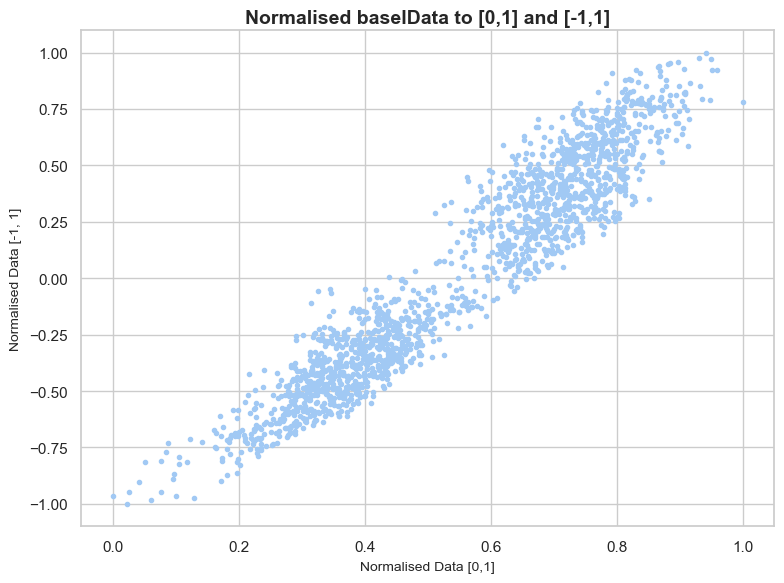

In [10]:
normalisedData = normalise(baselDataStandardised)
normalisedData2 = normalise2(baselDataStandardised)

plt.figure(figsize=(8, 6))
plt.plot(normalisedData[:,0], normalisedData2[:,1], ".")
plt.title('Normalised baselData to [0,1] and [-1,1]', fontsize = 14, weight='bold', pad=5)
plt.xlabel("Normalised Data [0,1]", fontsize = 10, labelpad =5)
plt.ylabel("Normalised Data [-1, 1]", fontsize=10, labelpad=5)
plt.tight_layout()
plt.show()

In [11]:
def centralise(data):
    centralisedData = data.copy()

    rows=data.shape[0]
    cols=data.shape[1]

    for j in range(cols):
        mu = np.mean(data[:,j])

        for i in range (rows):
            centralisedData[i,j] = (data[i,j] - mu)
    return centralisedData

In [12]:
baselDataConcat = normalisedData + normalisedData2

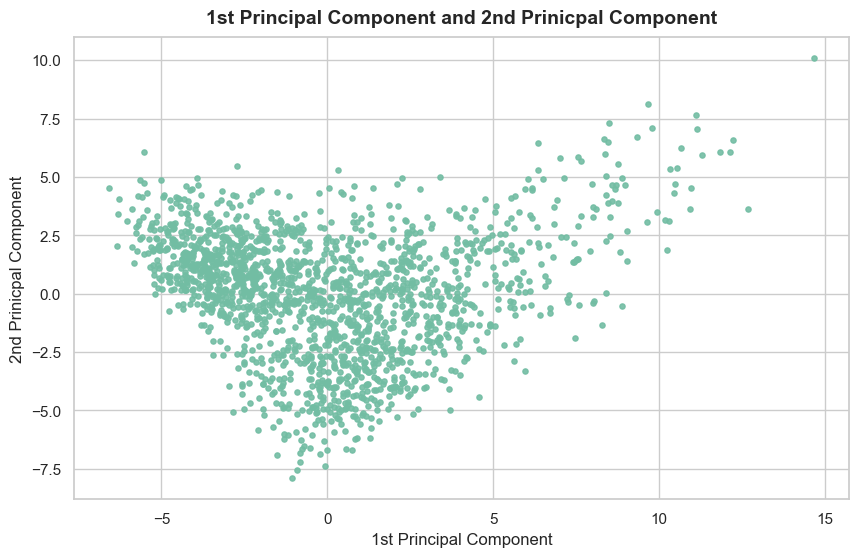

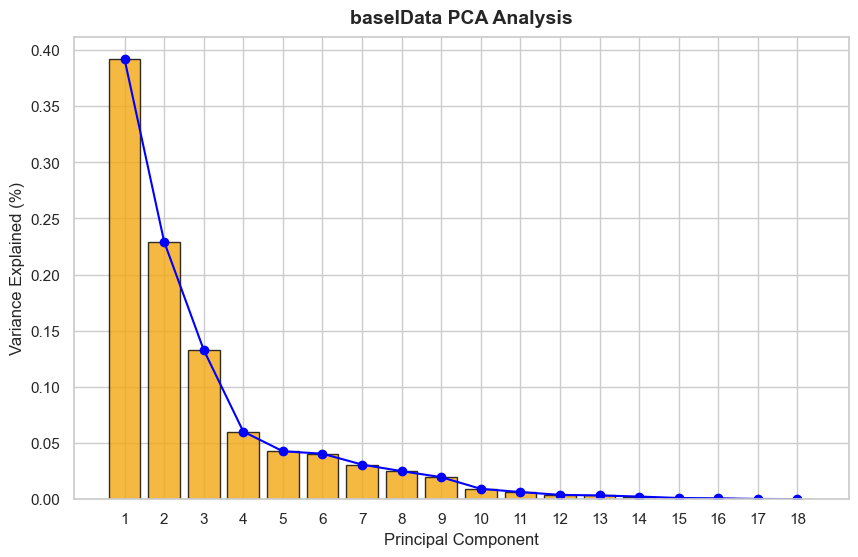

In [13]:
data = np.array(baselDataConcat)

#Start of PCA Algorithm
baselDataCentralised = centralise(data)

np.corrcoef(baselDataCentralised, rowvar=False)

pca = PCA(n_components=18)
pca.fit(baselDataCentralised)
Coeff = pca.components_

transformedBasel = pca.transform(baselDataCentralised)

plt.figure(figsize=(10,6))
plt.plot(transformedBasel[:,0], transformedBasel[:,1], '.', color='#72BDA3', alpha=.9, markersize=7.5)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Prinicpal Component')
plt.title('1st Principal Component and 2nd Prinicpal Component', fontsize=14, weight='bold', pad=10)
plt.savefig('BaselData PCA Data.png')

plt.figure(figsize=(10,6))
plt.bar([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], pca.explained_variance_ratio_, 
        tick_label=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],
        color='#F3A712', alpha=.8, edgecolor='black', linewidth=1 )
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")

plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 
         pca.explained_variance_ratio_, 
         color='blue', linestyle='-', marker='o', markersize=6, label='Explained Variance Line')

plt.title('baselData PCA Analysis', fontsize=14, weight='bold', pad=10)
plt.savefig("Basel Data PCA Analysis.png")


In [14]:
inertia =[]
for k in range(1, 11):
    kMeans = KMeans(n_clusters=k, random_state=42)
    kMeans.fit(transformedBasel)
    inertia.append(kMeans.inertia_)

x=range(1,11)
y=inertia

plt.plot(x, y, marker='*')
plt.title('Elbow Method for Optimal KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Distances Squared)')
plt.savefig('Elbow Method for Optimal KMeans.png')
plt.close()


C:\Users\joetr\AppData\Local\Temp\ipykernel_1404\1683039549.py:7: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=150, marker='x', label='Centroids', edgecolors='black')


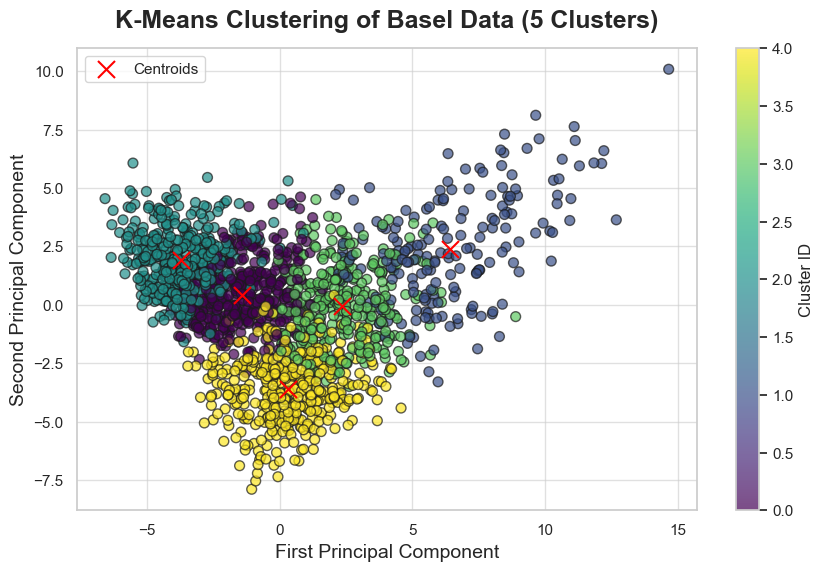

In [17]:
centroids, distortion = sc.vq.kmeans(transformedBasel, 5)
labels, distortion = vq(transformedBasel, centroids)
sns.set(style="whitegrid")  

plt.figure(figsize=(10, 6))
scatter = plt.scatter(transformedBasel[:, 0], transformedBasel[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7, edgecolors='k')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=150, marker='x', label='Centroids', edgecolors='black')

plt.title('K-Means Clustering of Basel Data (5 Clusters)', fontsize=18, weight='bold', pad=15)
plt.xlabel('First Principal Component', fontsize=14)
plt.ylabel('Second Principal Component', fontsize=14)

plt.colorbar(scatter, label='Cluster ID')
plt.legend(fontsize=9, loc='upper left', frameon=False, borderpad=1)

plt.grid(True, linestyle='-', alpha=0.6)

plt.savefig('kmeans.png', bbox_inches='tight', dpi=300)
plt.show()

In [81]:
transformedBaselScaled = scaler.fit_transform(transformedBasel) #standardise dataset

dbSCAN = DBSCAN(eps=3.8, min_samples=5) #perform DBSCAN clustering
dbSCAN.fit(transformedBaselScaled) #applying DBSCAN to transformed Dataset
dbLabels = dbSCAN.labels_ #extracts labels

noise = transformedBaselScaled[dbLabels == -1] #counts number of noise points
noiseCount = np.sum(dbLabels == -1)
print(f'Number of Noise Points: {noiseCount}')
plt.figure(figsize=(10,6))
plt.scatter(transformedBaselScaled[:,0], transformedBaselScaled[:,1], c=dbLabels, cmap='Spectral', s=20, alpha=.8) #selects features and colours based on labels
noiseMarkerSize = 10
if noise.shape[1] == 2:  # If the data has two features (2D data)
        plt.scatter(noise[:, 0], noise[:, 1], c='red', marker='x', label='Noise', alpha=.6, scaler=noiseMarkerSize)
else: 
        plt.scatter(noise[:, 0], np.zeros_like(noise[:, 0]), c='#f2dda4', marker='x', label='Noise', alpha=1, s=noiseMarkerSize)

plt.title(f'DBSCAN Clustering of Transformed Basel Data', fontsize=12, weight='bold', pad=5)
plt.xlabel('Feature One')
plt.ylabel('Feature Two')

plt.text(0.035, 0.92, f'Number of Noise Points: {noiseCount}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=9, color='black')
plt.legend(fontsize=9, loc='upper left', frameon=False, borderpad=1)
plt.grid(True, alpha=.5)
plt.tight_layout
plt.savefig('DBSCAN Clustering of Transformed Basel Data.png')
plt.close()


Number of Noise Points: 188


In [82]:
neighbours = NearestNeighbors(n_neighbors =10)
neighbours.fit(transformedBaselScaled)
distances, indices = neighbours.kneighbors(transformedBaselScaled)

distances = np.sort(distances[:, 1], axis=0)

sns.set(style='whitegrid', palette='muted')
plt.figure(figsize=(10,6))
plt.plot(distances, color='goldenrod', linestyle='-', markersize=3)
plt.title('K-Distance Graph for Basel Data', weight='bold', fontsize=14)
plt.xlabel('Points', fontsize=10)
plt.ylabel('Distance to Nearest Neighbour', fontsize=10)
plt.grid(True, alpha=.8)
plt.tight_layout

elbowPoint = 1750
plt.axvline(x=elbowPoint, color='lightgreen', linestyle='--', label=f'Elbow Point: {elbowPoint}', alpha=.6)
plt.legend(fontsize=9, loc='upper left', frameon=False, borderpad=1)
plt.savefig('Elbow Method for Optimal KMeans.png')
plt.close()

In [83]:
optimalEps = distances[elbowPoint]
print(f'Optimal EPS Value: {optimalEps}')

dbSCAN = DBSCAN(eps=optimalEps, min_samples=5) #perform DBSCAN clustering
dbSCAN.fit_predict(transformedBaselScaled) #applying DBSCAN to transformed Dataset
dbLabels = dbSCAN.labels_ #extracts labels

noise = transformedBaselScaled[dbLabels == -1] #counts number of noise points
noiseCount = np.sum(dbLabels == -1)
print(f'Number of Noise Points: {noiseCount}')


Optimal EPS Value: 5.964811689426372
Number of Noise Points: 12


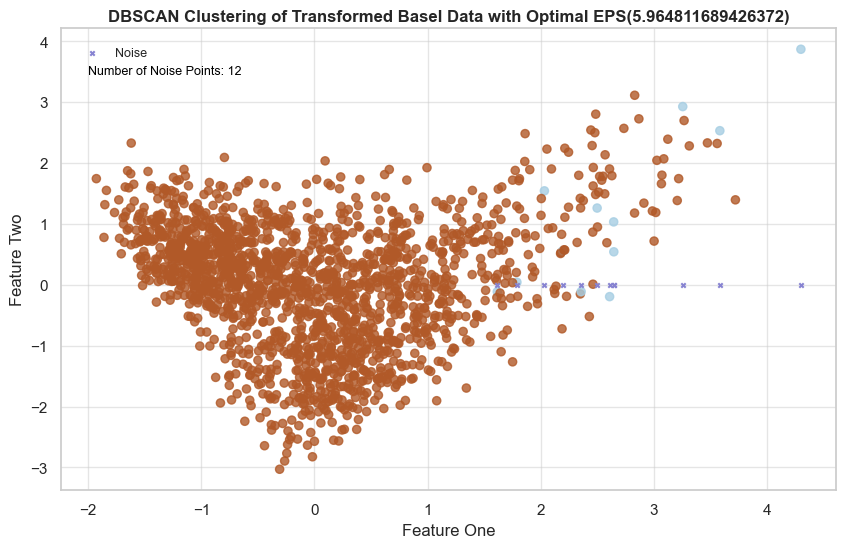

In [85]:
sns.set(style='whitegrid', palette='muted')
plt.figure(figsize=(10,6))
plt.scatter(transformedBaselScaled[:,0], transformedBaselScaled[:,1], c=dbLabels, cmap='Paired', s=35, alpha=.8) #selects features and colours based on labels
noiseMarkerSize = 10
if noise.shape[1] == 2:  #for(2D data)
        plt.scatter(noise[:, 0], noise[:, 1], c='red', marker='x', label='Noise', alpha=.6, scaler=noiseMarkerSize)
else: 
        plt.scatter(noise[:, 0], np.zeros_like(noise[:, 0]), c='#8783D1', marker='x', label='Noise', alpha=1, s=noiseMarkerSize)

plt.title(f'DBSCAN Clustering of Transformed Basel Data with Optimal EPS({optimalEps})', fontsize=12, weight='bold', pad=5)
plt.xlabel('Feature One')
plt.ylabel('Feature Two')

plt.text(0.035, 0.92, f'Number of Noise Points: {noiseCount}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=9, color='black')
plt.legend(fontsize=9, loc='upper left', frameon=False, borderpad=1)
plt.grid(True, alpha=.5)
plt.tight_layout
plt.savefig('DBSCAN Clustering of Transformed Basel Data with Optimal EPS.png')
plt.show()